## K-means algorithm

### The k-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset.

Those two assumptions are the basis of the k-means model:

• The “cluster center” is the arithmetic mean of all the points belonging to the cluster.

• Each point is closer to its own cluster center than to other cluster centers.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set() # for plot styling import numpy as np

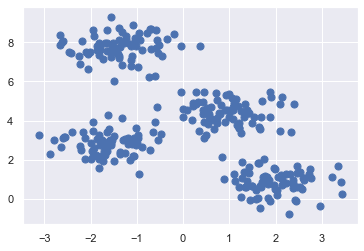

In [19]:
from sklearn.datasets.samples_generator import make_blobs 
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [20]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=4) 
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

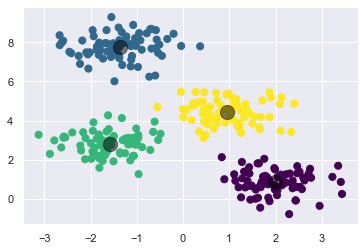

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Expectation–Maximization

### EM algorithm:

1. Guess some cluster centers

2. Repeat until converged
   
   a. E-Step: assign points to the nearest cluster center 
   
   b. M-Step: set the cluster centers to the mean

In [48]:
from sklearn.metrics import pairwise_distances_argmin
import numpy as np

In [49]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters] 
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center 
        labels = pairwise_distances_argmin(X, centers)
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        # 2c. Check for convergence
        if np.all(centers == new_centers): 
            break
        centers = new_centers 
        
    return centers, labels

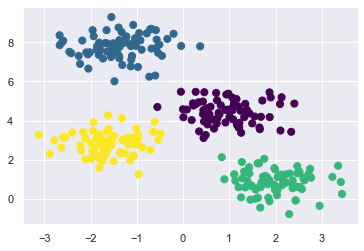

In [50]:
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### Caveats of expectation–maximization:

1. The globally optimal result may not be achieved
2. The number of clusters must be selected beforehand 
    - silhouette analysis (will discuss later)
3. k-means is limited to linear cluster boundaries
    - support vector machine (will discuss later)
    - SpectralClustering: It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm (below)
4. k-means can be slow for large numbers of samples
    - batch-based k-means algorithms: use a subset of the data to update the cluster centers at each step. One form of which is implemented in sklearn.cluster.MiniBatchKMeans

### Example of non-linear boundaries: use spectral clustering

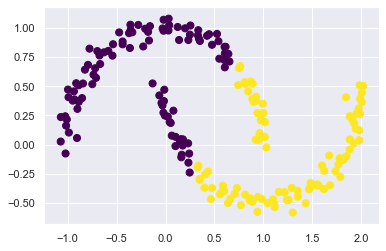

In [53]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


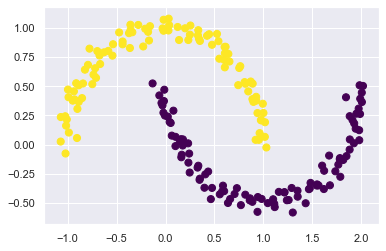

In [54]:
# Use spectral clustering:
from sklearn.cluster import SpectralClustering 
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

### Example 1: k-Means on digits

In [97]:
from sklearn.datasets import load_digits 
digits = load_digits()
digits.data.shape

(1797, 64)

In [102]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data) # predicted cluster
kmeans.cluster_centers_.shape

(10, 64)

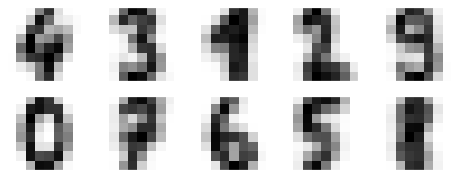

In [81]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3)) 
centers = kmeans.cluster_centers_.reshape(10, 8, 8) 
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [105]:
from scipy.stats import mode
labels = np.zeros_like(clusters) 
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [75]:
from sklearn.metrics import accuracy_score 
accuracy_score(digits.target, labels)

0.7952142459654981

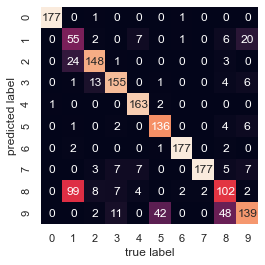

In [106]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. But this still shows that using k-means, we can essentially build a digit classifier without reference to any known labels!